<a href="https://colab.research.google.com/github/Nathalia-Prada/proyecto-integrador-equipo25/blob/main/Avance5Equipo25%20/Avance5Equipo25_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Avance 5. Modelo final Series de Tiempo: Forecasting con XGBoost**

3.5 Mejorar significativamente el rendimiento al aprovechar las fortalezas de diferentes modelos y reducir sus debilidades.

3.6 Evaluar la calidad de las predicciones del modelo en datos no vistos.


###**Equipo 25**


### Estudiantes


* A01793899 - Andrés Julián López Hurtado
* A01793999 - Nathalia Milena Prada Hernández
* A01794404 - Victor Alejandro Regueira Romero

Fecha: 27 de octubre de 2024

# Instrucciones
En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
Incluir la optimización de hiperparámetros para los modelos más relevantes.
Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.


Una vez que se han generado los modelos de ensamble, sintetizar los resultados en una tabla comparativa en la que se incluyan los modelos individuales de la fase previa.



Los modelos deben ser ordenados por la métrica principal, pero el resumen debe incorporar otras métricas pertinentes.
Se deberán incluir también los tiempos de entrenamiento.
Se elige el modelo final alineado con los objetivos y necesidades del negocio.



Del modelo elegido, generar algunos gráficos significativos con su interpretación. La siguiente lista proporciona ejemplos, pero no es exhaustiva:
- Curva ROC
- Matriz de confusión
- Curva de Precisión-Recall
- Análisis de residuos
- Gráfico de importancia de características
- Tendencia y predicción (para series temporales)
- Diagrama de árbol (para árboles de decisión)

# Importar Drive


In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerías


Se inicia importando las librerías y leyendo el dataset.

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Rutas de archivos y carga de la base

In [60]:
file_tabla_unida = '/content/drive/MyDrive/TECForza/df_union2.csv'
#file_tabla_unida = '/content/drive/MyDrive/0-Actual/MNA/proyecto_integrador/df_union2.csv'

In [61]:
df_tabla_unida = pd.read_csv(file_tabla_unida)
df_tabla_unida.head()

,name,date,total_distance_used_sum,total_fuel_used_sum,consumption,performance,distance,idlingDuration,idlingPercent,idlingDuration_hours,...,ExcessiveSpeedingCount,ExcessiveSpeedingDistance,HardAccelerationCount,HardAccelerationDistance,HarshBrakingCount,HarshBrakingDistance,HarshCorneringDuration,HarshCorneringCount,HarshCorneringDistance,MaxSpeed
0,986,2024-07-01,115.575006,15.321976,7.543088,0.132572,30.063228,08:12:02,87.0,8.20,...,159.0,50.848373,133.0,0.057267,1.0,0.000096,0.0,43.0,0.006195,83.885109
1,1038,2024-07-01,167.770170,25.096340,6.685045,0.149588,72.647624,06:53:43,62.0,6.90,...,19.0,2.382248,17.0,0.002865,0.0,0.000000,0.0,28.0,0.002594,76.428658
2,502,2024-07-02,1025.262150,68.948892,8.653096,0.067250,912.121800,11:00:31,46.0,11.01,...,105.5,38.452164,48.0,0.020623,0.5,0.000332,0.0,39.5,0.009367,42.874611
3,532,2024-07-02,1103.554896,75.817364,14.555437,0.068703,554.235964,01:34:01,14.0,1.57,...,3.5,0.055369,77.5,0.065764,0.0,0.000000,0.0,18.5,0.007460,38.835701
4,880,2024-07-02,857.491980,64.193796,13.357864,0.074862,429.840038,20:46:51,73.0,20.78,...,402.0,123.554245,59.0,0.020675,0.0,0.000000,0.0,37.0,0.020335,83.885109


# Variables seleccionadas y datasets

In [62]:
df_tabla_unida.columns

Index(['name', 'date', 'total_distance_used_sum', 'total_fuel_used_sum',
       'consumption', 'performance', 'distance', 'idlingDuration',
       'idlingPercent', 'idlingDuration_hours', 'CurrentFuelPrice',
       'IdlingCost', 'SpeedLimit1Count', 'SpeedLimit2Count',
       'SpeedLimit3Count', 'TotalDrivingDuration', 'AverageSpeed',
       'StopUnder10Count', 'StopOver10Count', 'StopOver20Count',
       'StopOver30Count', 'StopOver40Count', 'StopOver50Count',
       'IdlingOver5Count', 'IdlingDuration', 'AfterHoursTripCount',
       'TotalDistance', 'TotalStopsCount', 'SpeedingDuration', 'SpeedingCount',
       'SpeedingDistance', 'ExcessiveSpeedingDuration',
       'ExcessiveSpeedingCount', 'ExcessiveSpeedingDistance',
       'HardAccelerationCount', 'HardAccelerationDistance',
       'HarshBrakingCount', 'HarshBrakingDistance', 'HarshCorneringDuration',
       'HarshCorneringCount', 'HarshCorneringDistance', 'MaxSpeed'],
      dtype='object')

In [63]:
selected_columns = ['date', 'consumption']
df = df_tabla_unida[selected_columns]

Para el análisis de series de tiempo, se necesitan únicamente el consumo y la fecha del viaje, en este caso, las columnas `consumption` y `date`, respectivamente. Se asignará la columna `date` al índice del dataframe; sin embargo, antes debe convertirse de tipo *object* a *datetime* utilizando el método `to_datetime` de la librería Pandas. Finalmente, se muestra el consumo en una frecuencia de acumulado diario.

In [64]:
#convertir a datetime
df['date'] = pd.to_datetime(df['date'])
df_fc = df.set_index('date')

<ipython-input-64-6668be612607>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [65]:
#crear acumulado diario
count_date = df_fc.groupby(df_fc.index.date)['consumption'].sum()
fc_clean = pd.DataFrame(count_date)
fc_clean['date'] = pd.to_datetime(fc_clean.index)
fc_clean = fc_clean.set_index('date')

In [66]:
fc_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2024-07-01 to 2024-08-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  61 non-null     float64
dtypes: float64(1)
memory usage: 976.0 bytes


El primer paso en cualquier análisis de series de tiempo es graficar los datos. La visualización permite detectar patrones, lecturas atípicas, variaciones en el tiempo y la relación entre variables.

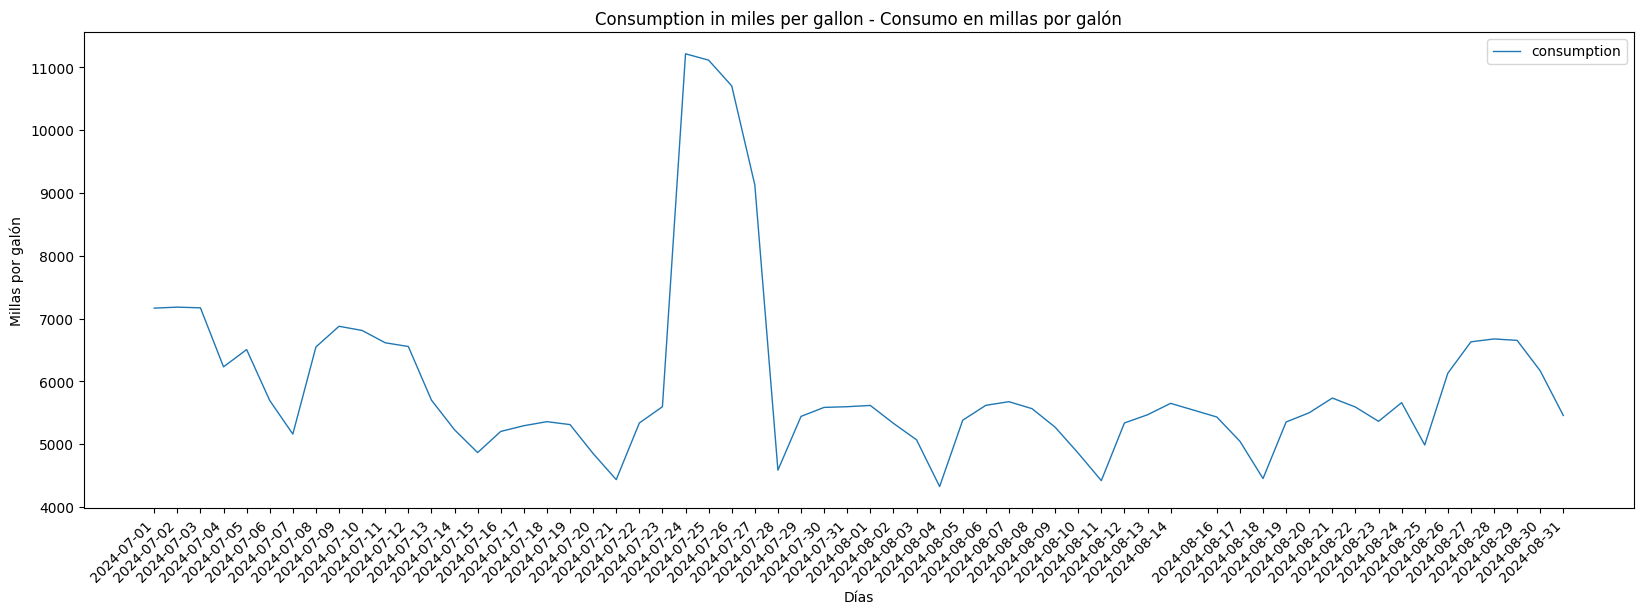

In [67]:
fc_clean.plot(style='-', figsize=(20, 7), lw=1, title='Consumption in miles per gallon - Consumo en millas por galón')

# Establecer la frecuencia de etiquetas del eje x para mostrar todos los días
plt.xticks(fc_clean.index, rotation=45)  # Rotación opcional para mejorar la visibilidad
plt.xlabel('Días')
plt.ylabel('Millas por galón')

plt.show()

# 1. Tendencias Generales
- **Disminución Inicial**: Desde el 1 de julio hasta el 8 de julio, se observa una ligera tendencia a la baja en el consumo, cayendo de aproximadamente 7166 a 5161.
- **Aumento Moderado**: Entre el 8 y el 15 de julio, el consumo muestra un aumento gradual, alcanzando un máximo de 6615 el 11 de julio.
- **Fluctuaciones a partir de la Segunda Quincena de Julio**: Desde el 15 de julio, el consumo comienza a fluctuar significativamente, con un notable aumento hacia el final del mes.

# 2. Picos de Consumo
- **Picos Notables**: Se identifican picos significativos en:
  - 24 de julio: 11,215.996 (consumo excepcionalmente alto).
  - 25 de julio: 11,114.945 (otro día de consumo muy alto).
  
  Estos dos días se destacan como anomalías en comparación con el resto del mes.

# 3. Tendencias en Agosto
- **Recuperación de Consumo**: Tras los picos de julio, el consumo desciende a valores más bajos en los primeros días de agosto, pero mantiene una tendencia moderadamente estable con ligeros picos y caídas.
- **Consumo en la Mitad de Agosto**: Hacia mediados de agosto, se observan incrementos progresivos, especialmente alrededor del 19 y 20 de agosto.
- **Fluctuaciones a Finales de Agosto**: Al final de agosto, el consumo muestra una variabilidad, pero en general se mantiene dentro de un rango similar al de principios de mes.

# Conclusiones
- **Picos en Consumo**: Los días 24 y 25 de julio muestran consumos extraordinarios, lo que podría indicar algún evento o actividad especial.
- **Tendencia a la Baja Inicial**: Después de los picos, el consumo disminuye, pero se observa cierta recuperación y variabilidad en agosto.
- **Consumo Generalmente Estable**: A pesar de las fluctuaciones, el consumo se mantiene en un rango relativamente constante a lo largo de agosto, con algunos picos y valles menores.

# Modelo XGBoost

XGBoost (Extreme Gradient Boosting) es una implementación avanzada del algoritmo Gradient Boosting (GBM) para tareas de aprendizaje supervisado, como regresión y clasificación. Este algoritmo utiliza ensambles de árboles de decisión (Tree Ensembles) para combinar múltiples modelos "débiles" y producir un modelo predictivo de mayor precisión. XGBoost aplica la técnica de boosting como método de ensamble y utiliza descenso de gradiente para optimizar el proceso, brindando gran flexibilidad en el ajuste de hiperparámetros para controlar la complejidad y mitigar el sobreentrenamiento (overfitting). También soporta el tratamiento de valores faltantes y variables categóricas.

Para este análisis, solo se ajustarán los siguientes hiperparámetros:

- **booster**: Tipo de modelo utilizado; por defecto, `gbtree`, que emplea árboles de decisión.
- **n_estimators**: Número de modelos en el ensamble. Un valor bajo puede causar underfitting, mientras que uno muy alto puede llevar al sobreentrenamiento.
- **early_stopping_rounds**: Número de iteraciones tras el cual se detiene automáticamente el entrenamiento si no mejora el score de validación. Este parámetro suele utilizarse con un valor alto de `n_estimators`, permitiendo que `early_stopping_rounds` determine el número óptimo de iteraciones.
- **objective**: Define la tarea de aprendizaje y el objetivo de optimización. En este caso, se especifica `'reg:squarederror'` para regresión con error cuadrático.
- **reg_lambda**: Parámetro de regularización, equivalente a Ridge (L2) en regresiones múltiples, que penaliza de forma uniforme todos los pesos del modelo. Un valor más alto hace el modelo más conservador.
- **max_depth**: Profundidad máxima de los árboles de decisión. Una mayor profundidad puede mejorar el ajuste, pero incrementa el riesgo de sobreentrenamiento.
- **eta**: Tasa de aprendizaje en cada iteración. Un valor mayor permite una convergencia más rápida, aunque podría "saltar" el valor óptimo; un valor menor ofrece un ajuste más gradual, aunque puede no alcanzar el mínimo de la función objetivo.

## Creación de Atributos (feature engineering)

De momento, el dataset solo contiene la variable de salida ('Consumption in miles per gallon - Consumo en millas por galón).

El siguiente paso consiste en agregar características que ayuden a explicar el comportamiento de esta variable. Para ello, se aprovechan los métodos de la librería Pandas para manipular datos de tipo `datetime`. Se define una función para crear variables adicionales basadas en el índice de la serie de tiempo:

In [68]:
def create_attributes(df):
    df = df.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

fc_clean = create_attributes(fc_clean)
fc_clean

,consumption,day,dayofweek,month,quarter,year,dayofyear
date,,,,,,,
2024-07-01,7166.415676,1,0,7,3,2024,183
2024-07-02,7182.232302,2,1,7,3,2024,184
2024-07-03,7171.074568,3,2,7,3,2024,185
2024-07-04,6231.688432,4,3,7,3,2024,186
2024-07-05,6506.612911,5,4,7,3,2024,187
...,...,...,...,...,...,...,...
2024-08-27,6630.083851,27,1,8,3,2024,240
2024-08-28,6675.791509,28,2,8,3,2024,241
2024-08-29,6653.025786,29,3,8,3,2024,242


### Entrenando el Modelo

Antes del entrenamiento, se divide el conjunto de datos en un set de prueba y otro de validación. Es importante recordar que, en el caso de series de tiempo, no es adecuado realizar una división aleatoria para la validación cruzada (cross-validation), debido a la correlación entre observaciones cercanas en el tiempo.

Para abordar esto, se utiliza la clase `TimeSeriesSplit` de la librería Scikit-learn. Se dividen los datos en 4 particiones para la validación cruzada, y la métrica de evaluación seleccionada será el error cuadrático medio (RMSE).

In [69]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

#dividir en 4 folds
ts_cv = TimeSeriesSplit(n_splits=4)

fold = 0
preds = []
scores = []

for train_idx, val_idx in ts_cv.split(fc_clean):
    train = fc_clean.iloc[train_idx]
    test = fc_clean.iloc[val_idx]

    #agregar atributos al set de entrenamiento y prueba
    train = create_attributes(train)
    test = create_attributes(test)

    features = ['day','dayofweek','month','quarter','year','dayofyear']
    target = ['consumption']

    #dividir atributos y variable de salida
    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]

    #crear instancia del regresor
    xgb_reg = xgb.XGBRegressor(booster='gbtree',
                               seed=42,
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:squarederror',
                               reg_lambda=0.001,
                               max_depth=5,
                               eta=0.01)
    #entrenar modelo
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

    #predicciones y evaluacion
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:599.05407	validation_1-rmse:2282.85056
[100]	validation_0-rmse:219.86611	validation_1-rmse:2190.46728
[200]	validation_0-rmse:80.94697	validation_1-rmse:2169.75528
[300]	validation_0-rmse:29.71525	validation_1-rmse:2163.86591
[400]	validation_0-rmse:10.90637	validation_1-rmse:2161.98964
[500]	validation_0-rmse:4.00096	validation_1-rmse:2161.35954
[600]	validation_0-rmse:1.46765	validation_1-rmse:2161.13329
[700]	validation_0-rmse:0.53821	validation_1-rmse:2161.05077
[800]	validation_0-rmse:0.19815	validation_1-rmse:2161.02063
[900]	validation_0-rmse:0.07392	validation_1-rmse:2161.01340
[999]	validation_0-rmse:0.03108	validation_1-rmse:2161.00917
[0]	validation_0-rmse:1618.25634	validation_1-rmse:1826.85788
[60]	validation_0-rmse:890.91722	validation_1-rmse:2164.69380
[0]	validation_0-rmse:1682.08589	validation_1-rmse:1087.31528
[100]	validation_0-rmse:622.53180	validation_1-rmse:434.25976
[200]	validation_0-rmse:231.31205	validation_1-rmse:201.33373
[300]	validati

### Análisis de los Resultados

1. **Evaluación de la Métrica RMSE**:
   - **`validation_0`**: RMSE de este conjunto de validación, utilizado para monitorear el ajuste del modelo durante el entrenamiento.
   - **`validation_1`**: RMSE de un segundo conjunto de validación, crucial para evaluar la capacidad de generalización del modelo.

### Primer conjunto de resultados

En el primer conjunto de iteraciones, el RMSE para `validation_0` disminuye considerablemente desde **599.05** en la iteración 0 hasta **0.03** en la iteración 999. Sin embargo, el RMSE para `validation_1` se mantiene relativamente constante alrededor de **2161**. Esto sugiere que, aunque el modelo se está ajustando muy bien a `validation_0`, puede estar sobreajustándose a este conjunto y no generaliza bien a `validation_1`.

### Segundo conjunto de resultados

En la primera iteración del segundo conjunto, el RMSE de `validation_0` es **1618.25**, que disminuye significativamente a **890.92** en la iteración 60. Sin embargo, el RMSE de `validation_1` muestra un valor inicial de **1826.85**, que no parece mejorar. Esto puede indicar que el modelo tiene dificultades para aprender patrones que generalicen a `validation_1`.

### Tercer conjunto de resultados

En el tercer conjunto, `validation_0` también muestra una disminución significativa de **1682.09** a **16.84**. Para `validation_1`, el RMSE mejora de **1087.32** a **120.43**, lo que indica una mejor capacidad de generalización del modelo en comparación con los resultados anteriores.

### Cuarto conjunto de resultados

En el cuarto conjunto, el RMSE para `validation_0` disminuye de **1537.76** a **943.39**, pero el RMSE para `validation_1` es de **554.55** a **1322.27**, lo que sugiere un rendimiento inconsistente y la posibilidad de sobreajuste.

### Conclusiones Generales

1. **Sobreajuste**: En los primeros resultados, el modelo parece estar sobreajustándose a `validation_0`, dado que el RMSE es significativamente bajo mientras que `validation_1` no mejora.
2. **Generalización**: En el tercer conjunto, el modelo muestra mejoras en la generalización, lo que sugiere que ajustes en los hiperparámetros o la selección de características pueden haber mejorado su rendimiento.
3. **Recomendaciones**:
   - Evaluar la regularización y otros hiperparámetros para evitar el sobreajuste.
   - Considerar la validación cruzada utilizando `TimeSeriesSplit` para obtener un mejor entendimiento del rendimiento del modelo en datos no vistos.
   - Realizar un análisis de la importancia de las características para identificar qué variables están contribuyendo más al rendimiento del modelo.

In [70]:
print('Fold scores:', scores)
print('Avg. Score:', np.mean(scores))

Fold scores: [2161.009220977126, 1796.3882068081723, 120.00823027294715, 554.5493568953679]
Avg. Score: 1157.9887537384034


### Visualización del Proceso de Validación Cruzada

La gráfica del proceso de validación cruzada nos permite obtener una perspectiva visual sobre cómo se entrenó el modelo y cómo varían los resultados a través de los distintos pliegues de validación. A continuación, generamos esta visualización con el siguiente código:

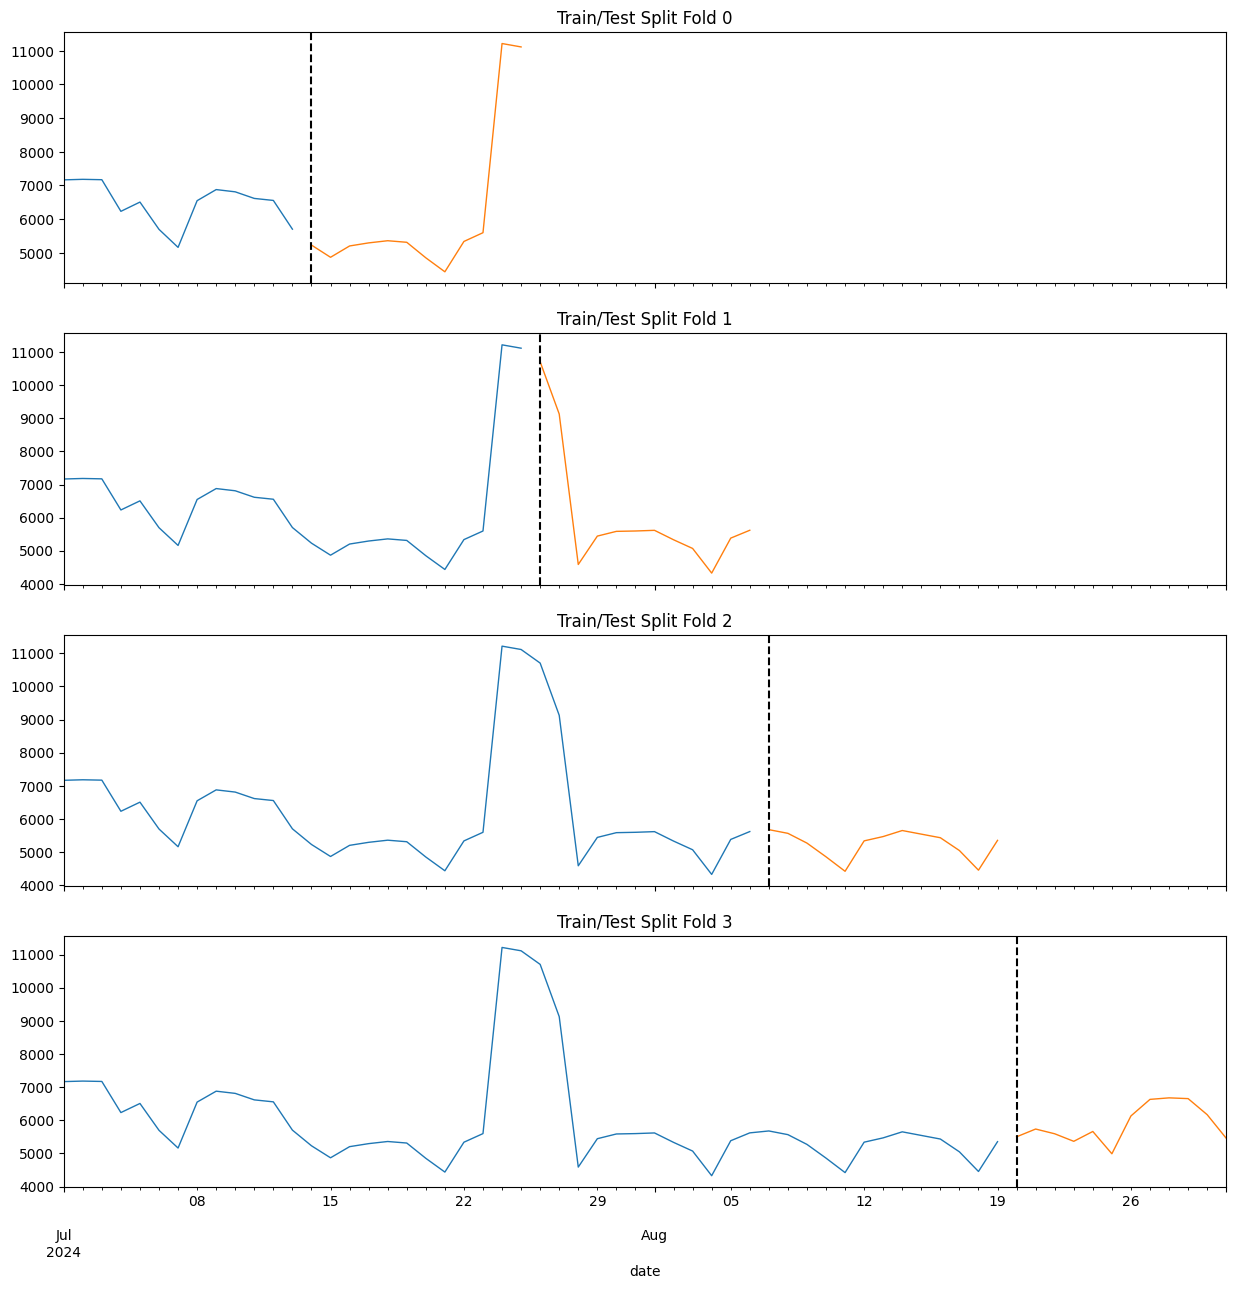

In [71]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in ts_cv.split(fc_clean):
    train = fc_clean.iloc[train_idx]
    test = fc_clean.iloc[val_idx]
    train['consumption'].plot(ax=axs[fold], lw=1,
                      label='Training Set',
                      title=f'Train/Test Split Fold {fold}')
    test['consumption'].plot(ax=axs[fold], lw=1,
                     label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Predicción del Futuro

Primero, se reentrena el modelo utilizando todos los datos disponibles. Esto permite aprovechar al máximo la información, ya que las predicciones se realizarán a partir de la última fecha registrada en el conjunto de datos:

In [72]:
#crear dataframe completo
fc_clean = create_attributes(fc_clean)

features = ['day','dayofweek','month','quarter','year','dayofyear']
target = ['consumption']

X_full = fc_clean[features]
y_full = fc_clean[target]

In [73]:
#crear instancia del regresor
xgb_regf = xgb.XGBRegressor(booster='gbtree',
                            seed=42,
                            n_estimators=1000,
                            early_stopping_rounds=50,
                            objective='reg:squarederror',
                            reg_lambda=0.001,
                            max_depth=5,
                            eta=0.01)
#entrenar modelo
xgb_regf.fit(X_full, y_full,
        eval_set=[(X_full, y_full)],
        verbose=100)

[0]	validation_0-rmse:1398.93073
[100]	validation_0-rmse:518.71458
[200]	validation_0-rmse:196.98125
[300]	validation_0-rmse:78.20273
[400]	validation_0-rmse:34.59726
[500]	validation_0-rmse:16.54902
[600]	validation_0-rmse:10.04966
[700]	validation_0-rmse:6.63475
[800]	validation_0-rmse:4.60504
[900]	validation_0-rmse:3.11770
[999]	validation_0-rmse:2.26770


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

### Resultados

- **Inicio del entrenamiento**: En la primera iteración (0), el RMSE es **1398.93**, indicando que el modelo aún no hace predicciones precisas.
- **Mejoras a través de las iteraciones**: A medida que avanza el entrenamiento, el RMSE disminuye notablemente:
  - En la iteración 100, el RMSE es **518.71**.
  - En la iteración 200, el RMSE se reduce a **196.98**.
  - En la iteración 300, llega a **78.20**.
- **Convergencia**: En las últimas iteraciones, el RMSE sigue disminuyendo, aunque más lentamente:
  - En la iteración 600, el RMSE es **10.05**.
  - Finalmente, en la iteración 999, el RMSE se estabiliza en **2.27**.

### Conclusiones

1. **Buen ajuste**: El modelo muestra una mejora continua en su capacidad predictiva.
2. **Detención anticipada**: Si se usó `early_stopping_rounds=50`, el entrenamiento podría haberse detenido antes de alcanzar la iteración 999.

A continuación, se crea un nuevo dataframe que incluye las fechas a pronosticar. Posteriormente, este dataframe se concatena con el dataframe original, añadiendo una columna booleana para identificar las fechas correspondientes al futuro.

En este caso, se pronostican 4 meses hacia adelante. Para generar el rango de fechas en la frecuencia deseada, se utiliza el método `date_range` de Pandas, configurado para obtener fechas diarias:

In [74]:
#rango de septiembre a diciembre 2024
pred_dates = pd.date_range('2024-09-01','2024-12-31', freq='D')
preds_df = pd.DataFrame(index=pred_dates)

#Crear columna
preds_df['Future'] = True
fc_clean['Future'] = False

#Concatenar dataframes
pred_fc = pd.concat([fc_clean.loc[fc_clean.index >= '01-01-2018'], preds_df])

Se agregan atributos mediante la función `create_attributes` y, finalmente, se genera un dataframe con las fechas futuras para realizar el pronóstico. El dataframe "futuro" se usará como entrada del modelo, mientras que el dataframe "completo" permitirá visualizar la serie de tiempo final:

In [75]:
#agregar atributos
pred_fc = pred_fc.copy()
pred_fc = create_attributes(pred_fc)

#seleccionar fechas
future_pred_fc = pred_fc.query('Future').copy()
future_pred_fc.head()

,consumption,day,dayofweek,month,quarter,year,dayofyear,Future
2024-09-01,NaN,1,6,9,3,2024,245,True
2024-09-02,NaN,2,0,9,3,2024,246,True
2024-09-03,NaN,3,1,9,3,2024,247,True
2024-09-04,NaN,4,2,9,3,2024,248,True
2024-09-05,NaN,5,3,9,3,2024,249,True


# Pronóstico

Se asignan los valores pronosticados a una nueva columna llamada `prediction`, y finalmente, se genera una gráfica que muestra tanto los datos históricos como el pronóstico obtenido.

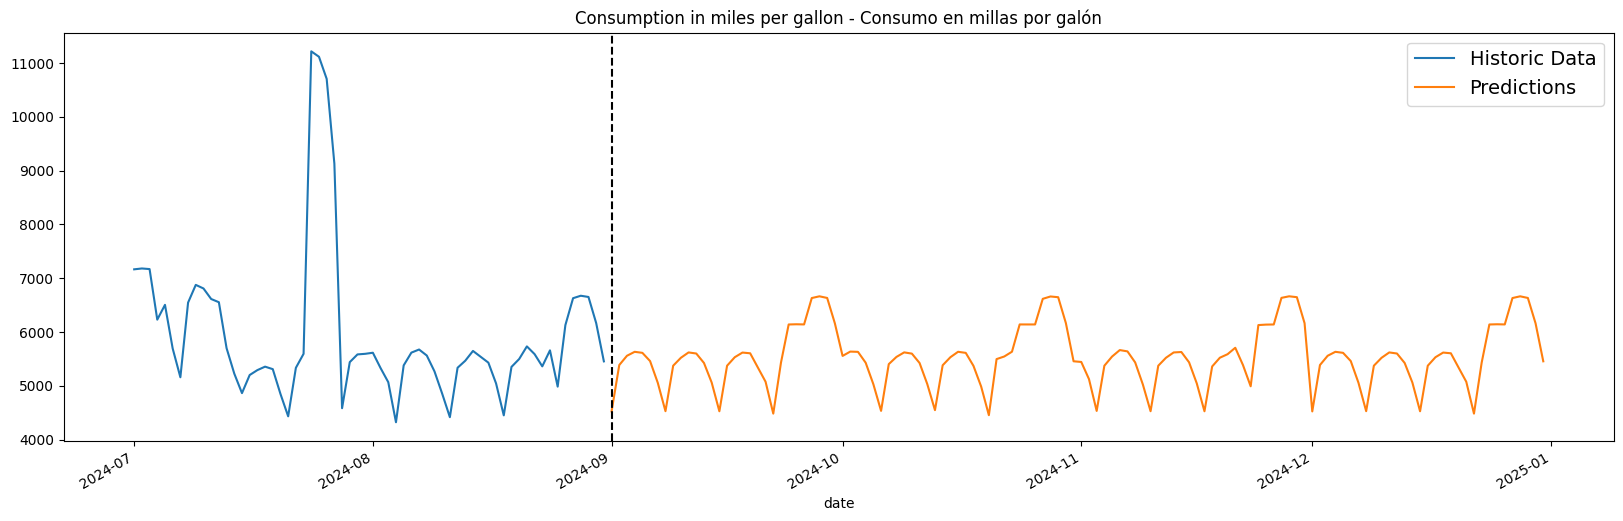

In [76]:
#predicciones del modelo
future_pred_fc['prediction'] = xgb_regf.predict(future_pred_fc[features])

#graficar
ax = fc_clean['consumption'].loc[fc_clean.index >= '01-01-2018']\
    .plot(figsize=(20, 6), lw=1.5, title='Consumption in miles per gallon - Consumo en millas por galón')
future_pred_fc['prediction'].plot(style='-', lw=1.5)
ax.axvline('2024-09-01', color='black', ls='--', lw=1.5)
plt.legend(['Historic Data','Predictions'], fontsize=14)
plt.show()